In [57]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
pgf_with_rc_fonts = {
    "text.usetex": True,
    "text.latex.unicode": True,
    "font.family": "serif",
    "font.serif": [],                   # use latex default serif font
    "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
    "pgf.preamble": [
        r'\usepackage{amsmath}',
        r'\usepackage{gensymb}',
        r'\usepackage{siunitx}',
        r'\DeclareSIUnit{\revolution}{rev}',
    ]
}
matplotlib.rcParams.update(pgf_with_rc_fonts)

import matplotlib.pyplot as plt

import pandas as pd
import os

# Background Color
bg = '#d3e9f8'

import ingest
import numpy as np
df = ingest.setup('../../valid/capture/capture1')

Dropped 1 outlier coordinate


In [58]:
import warnings
from bearing_error import error, error_methods, smoothing_methods
warnings.filterwarnings('ignore')
errors = error(df, list(error_methods.keys()))
#errors_uncorrected = ingest.error(ingest.error_methods, true_bearing=False)
#errors_dbm = ingest.error(ingest.error_methods, mw=False)

HBox(children=(IntProgress(value=0, description='Preparing data', max=4342), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Interpolating', max=47762), HTML(value='')))

In [59]:
# Print the median results by method
for smooth in pd.unique(errors.smooth):
    errors_display = errors[errors.smooth==smooth].groupby(['method'])['error'].apply(lambda x: pd.Series.median(pd.Series.abs(x))).sort_values()
    #errors_display.plot(kind='bar', title="Overall")
    print(errors_display)
errors_display = errors[errors.smooth.isnull()].groupby(['method'])['error'].apply(lambda x: pd.Series.median(pd.Series.abs(x))).sort_values()
#errors_display.plot(kind='bar', title="Overall")
print(errors_display)

# Errors in dbm
#errors_display_dbm = errors_display = errors_dbm.groupby('method')['error'].apply(lambda x: pd.Series.median(pd.Series.abs(x))).sort_values()
#print(errors_display_dbm)

Series([], Name: error, dtype: float64)
method
PCHIP          13.697475
BPoly          14.312019
Naive          14.697475
SLinear        14.827605
Linear         15.092330
Akima          16.441210
Barycentric    22.827605
Cubic          24.942384
Quadratic      25.697475
Krogh          59.284347
Random         89.997974
Name: error, dtype: float64


In [60]:
errors_display = errors.groupby(['method'])['error'].apply(lambda x: pd.Series.median(pd.Series.abs(x))).sort_values()
#errors_display.plot(kind='bar', title="Overall")
print(errors_display)

method
PCHIP          13.697475
BPoly          14.312019
Naive          14.697475
SLinear        14.827605
Linear         15.092330
Akima          16.441210
Barycentric    22.827605
Cubic          24.942384
Quadratic      25.697475
Krogh          59.284347
Random         89.997974
Name: error, dtype: float64


BrokenPipeError: [Errno 32] Broken pipe

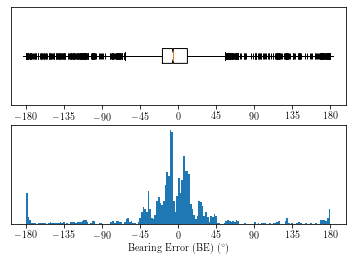

In [61]:
errpchip = errors[errors.method=='PCHIP'].error

f, (ax1, ax2) = plt.subplots(2, sharex=False)
ax1.boxplot(errpchip, 1, vert=False, sym='+')

# label = f"Optimal CHD (median: {format(data['discovery-hop-dist-2'].median(), '.2f')} "
plt.rcParams["figure.figsize"] = [6, 4]
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax1.tick_params(axis='y', which=u'both',length=0)
ax2.tick_params(axis='y', which=u'both',length=0)
ax1.set_xticks([x for x in range(-180,181,45)])
ax2.set_xticks([x for x in range(-180,181,45)])

plt.xlabel(r'Bearing Error (BE)  ($^\circ$)')


ax2.hist(errpchip, 180)
f.savefig('pchiperr.pgf')

errpchip.describe()

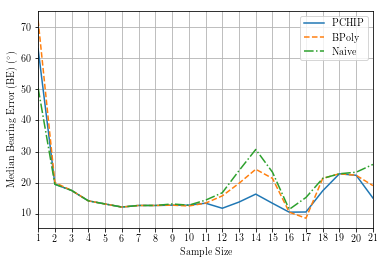

In [62]:
# For display purposes, eliminate Random and Krogh
median_errors = errors.groupby(['method', 'samples'])['error'].apply(lambda x: pd.Series.median(pd.Series.abs(x))).unstack().T
median_errors_reduced = median_errors[['PCHIP', 'BPoly', 'Naive']]
#median_errors_reduced = median_errors
ax = median_errors_reduced.plot(xticks=median_errors_reduced.index.values, grid=True, style=['-','--','-.',':'])
ax.set_ylabel("Median Bearing Error (BE) ($^\circ$)")
ax.set_xlabel("Sample Size")
ax.legend(bbox_to_anchor=(1,1))
plt.savefig('interpolation_grid.pgf')

BrokenPipeError: [Errno 32] Broken pipe

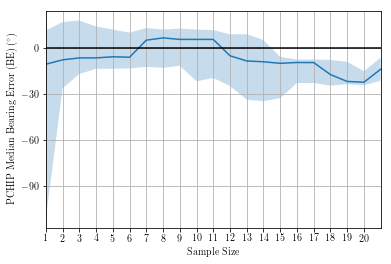

In [63]:
pchip = errors[errors.method=='PCHIP'].groupby('samples')['error']
pchip_median = pchip.apply(lambda x: pd.Series.median(pd.Series.abs(x)))
pchip_error = pchip.std()
pchip_lq = pchip.quantile([0.25])
pchip_uq = pchip.quantile([0.75])
pchip_med = pchip.quantile([0.50])
pchip_min = pchip.quantile([0])
pchip_max = pchip.quantile([1])

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(pchip_med.index.get_level_values(level=0), pchip_med.values)
ax.fill_between(pchip_med.index.get_level_values(level=0), pchip_lq.values, pchip_uq.values, antialiased=True, alpha=0.25, linestyle='-')

# # ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel("PCHIP Median Bearing Error (BE) ($^\circ$)")
ax.set_xlabel("Sample Size")
ax.set_xticks([x for x in range(0, 21)])
ax.set_yticks([y for y in range(-120,181,30)])
ax.set_xlim([1,21])
ax.grid()
ax.plot([0,21],[0,0],'k')
plt.savefig('interpolation_pchip.pgf')

BrokenPipeError: [Errno 32] Broken pipe

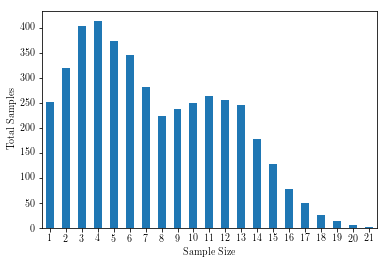

In [64]:
sample_spread = errors[errors['method']=='Naive'].groupby(['samples'])['error'].count().T

fig = plt.figure()
ax = plt.subplot(111)
sample_spread.plot(ax = ax, kind='bar', stacked=True)
plt.xticks(rotation=0)
ax.set_ylabel("Total Samples")
ax.set_xlabel("Sample Size")
plt.savefig('interpolation_spread.pgf')

# variance_spread = errors[errors['method']=='Naive'].groupby(['test','samples'])['error'].var().unstack().T
# variance_spread.plot(kind='bar', stacked=True, title="Variance per Sample Size")


In [28]:
import locate
from bearing_error import prep_for_plot
def get_nsample_set(n):
    rando = errors[(errors['samples']==n) & (errors['method']=='naive')].reset_index()
    i = np.random.randint(len(rando))
    test = rando.iloc[i]['test']
    pass_n = rando.iloc[i]['pass']
    bssid = rando.iloc[i]['bssid']
    return ingest.get_set(test, pass_n, bssid), test, bssid

the_set, test, bssid = get_nsample_set(5)
series = prep_for_plot(the_set)

interp = locate.interpolate(series, 'pchip')


ValueError: low >= high

In [29]:
# Show the best methods for each number of samples
ntop = 5
idx = pd.MultiIndex.from_product([['method','error'],range(0,5)])
top_methods = median_errors.T.apply(lambda x: pd.Series(pd.concat([pd.Series(x.nsmallest(ntop).index, dtype=np.dtype(object)), pd.Series(x.nsmallest(ntop).values, dtype=np.dtype(object))])))
top_methods.set_index(idx, inplace=True)
top_methods = top_methods.swaplevel(1,0).sort_index()
top_methods

samples            1        2            3          4          5        6   \
0 error      0.461349  1.02958     0.436048   0.384175       2.19  4.70495   
  method    Quadratic    Akima        Krogh      Cubic      Krogh    Akima   
1 error       5.73581  6.02958     0.918016    1.38418    2.41502  5.09233   
  method  Barycentric   Random    Quadratic  Quadratic  Quadratic    Cubic   
2 error        7.0705  6.99766      2.38418    5.99361    3.14344  5.99766   
  method        Cubic    Naive        Cubic     Random      Cubic    BPoly   
3 error        7.0705  7.43605      2.44121    6.43605     4.5705  5.99766   
  method        Naive  SLinear  Barycentric      Akima      Akima   Linear   
4 error       7.74177  7.70495      5.33466    6.43605    5.70495  5.99766   
  method       Random    BPoly        Akima      BPoly      BPoly    Naive   

samples            7            8            9            10     ...       \
0 error       2.14134     0.226954      3.94238     0.128072     ...        
  method       Random    Quadratic        Akima  Barycentric     ...        
1 error       2.67666     0.871928      4.63533      1.87193     ...        
  method        Cubic        Cubic  Barycentric        Cubic     ...        
2 error       3.43114      1.08198      5.22695      1.87193     ...        
  method    Quadratic        Krogh       Linear       Linear     ...        
3 error       3.94615      2.22695      5.22695      1.87193     ...        
  method  Barycentric        Akima        Naive        Naive     ...        
4 error       4.87727      5.63533      5.63533      1.87193     ...        
  method        BPoly  Barycentric        BPoly    Quadratic     ...        

samples          12       13       14         15       16       17         18  \
0 error      1.8276  8.43864  0.74604    1.78394  9.43864  8.49283     4.8276   
  method      Krogh    BPoly   Random     Random    BPoly    Akima      Krogh   
1 error      2.2043  8.43864  8.96573    9.96573  9.43864  8.49283    8.00717   
  method     Random    PCHIP    PCHIP      PCHIP    PCHIP    BPoly     Random   
2 error     5.05345  8.43864  9.96573    12.4928  9.49283  8.49283    12.4928   
  method      PCHIP  SLinear    Akima      Akima   Linear   Linear      Cubic   
3 error      5.6629  8.49283  10.4657    12.9657  9.49283  8.49283    12.4928   
  method      BPoly    Akima    Cubic      Cubic    Naive    Naive  Quadratic   
4 error     7.30252  8.49283  10.9386    12.9657  9.49283  8.49283    14.9405   
  method  Quadratic   Linear    BPoly  Quadratic  SLinear  SLinear      Akima   

samples        19           20           21  
0 error   21.8276      22.3276       9.8276  
  method    Akima        BPoly        BPoly  
1 error   21.8276      22.3276      13.8276  
  method    BPoly       Linear        PCHIP  
2 error   21.8276      22.3276      20.8276  
  method   Linear        PCHIP       Linear  
3 error   21.8276      22.3276      20.8276  
  method    PCHIP      SLinear      SLinear  
4 error   21.8276      23.3276      25.8276  
  method  SLinear  Barycentric  Barycentric  

[10 rows x 21 columns]

Dropped 1 outlier coordinate


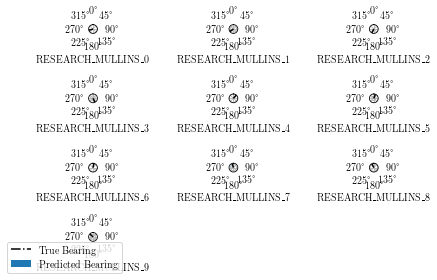

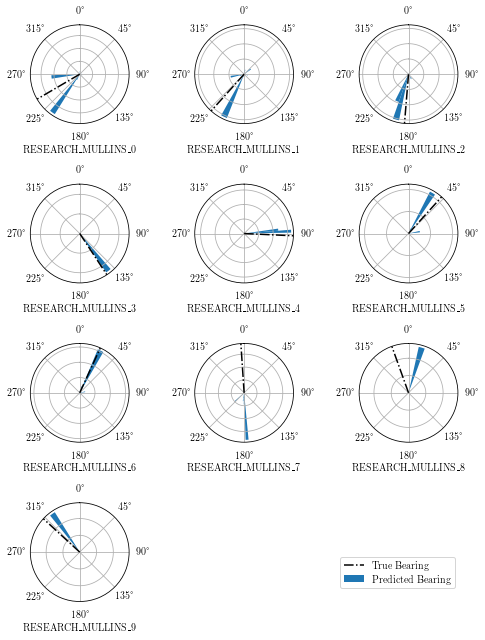

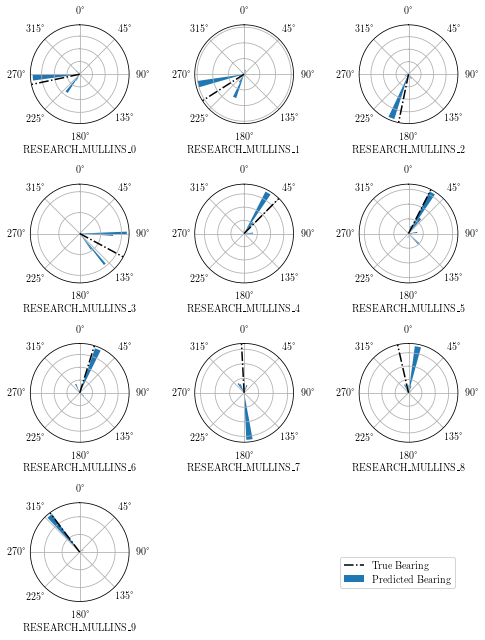

In [13]:
import capmap
capmap.setup('../../valid/capture/capture1', df)

cols = 3
rows = 4
bssids = capmap.aps.BSSID
bearings = capmap.bearings


for test in pd.unique(df.test):
    f, axarr = plt.subplots(rows,cols, subplot_kw=dict(polar=True))
    counter = 0
    for i in range(rows):
        for j in range(cols):      
            ax = axarr[i, j]
            if(counter) >= len(bssids): 
                f.delaxes(ax)
                continue
            bssid = bssids[counter]
            guesses = errors[(errors.test==test) & (errors.method=='PCHIP') & (errors.bssid==bssid)].guess
            if len(guesses) == 0:
                f.delaxes(ax)
                continue

            ax.set_yticklabels([])
            ax.set_theta_offset(np.radians(90))
            ax.set_theta_direction(-1)
            ax.set_xlabel(capmap.get_names_from_bssid([bssid], concat=False, escape=True)[0])
            bars = ax.hist(np.radians(guesses), bins=45, label="Predicted Bearing")
            truth = bearings[(bearings.test==test) & (bearings.bssid==bssid)].bearing.values[0]
            ax.axvline(np.radians(truth), 0, 1, color='k', linestyle='-.', label="True Bearing")

            counter += 1
   
    plt.rcParams["figure.figsize"] = [7, 9]
    plt.tight_layout()
    plt.legend(loc='upper right', bbox_to_anchor=(4.35, 0.5))
    plt.savefig(f'pchip_errors_{test}.png', dpi=300)
    plt.show()



Dropped 1 outlier coordinate


BrokenPipeError: [Errno 32] Broken pipe

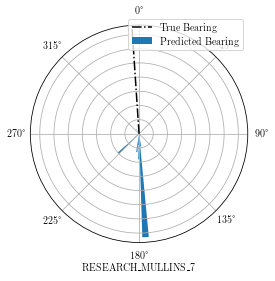

In [65]:
import capmap
capmap.setup('../../valid/capture/capture1', df)

bssid = capmap.get_bssids_from_names('RESEARCH_MULLINS_7')
bearings = capmap.bearings
test = 'capture-3'


f, ax = plt.subplots(1,1, subplot_kw=dict(polar=True))

guesses = errors[(errors.test==test) & (errors.method=='PCHIP') & (errors.bssid==bssid)].guess

ax.set_yticklabels([])
ax.set_theta_offset(np.radians(90))
ax.set_theta_direction(-1)
ax.set_xlabel(capmap.get_names_from_bssid([bssid], concat=False, escape=True)[0])
bars = ax.hist(np.radians(guesses), bins=45, label="Predicted Bearing")
truth = bearings[(bearings.test==test) & (bearings.bssid==bssid)].bearing.values[0]
ax.axvline(np.radians(truth), 0, 1, color='k', linestyle='-.', label="True Bearing")

plt.legend(loc='upper right', bbox_to_anchor=(1, 1.05))
plt.savefig('pchip_polar.pgf')
plt.show()

